# Capstone 1 Project - Black Friday Prediction

### Description
The dataset is a sample of the transactions on a Black Friday from a retail store. The store is interested in predicting customer purchases for different products. In this, they are particularly interested in predicting the amount of purchase based on previous purchase patterns. 

There can also be some classification done on some variables. Like predicting the sex of the customer, age of the customer etc. But we will not be exploring that.

##### Acknowledgements
The dataset comes from a competition hosted by Analytics Vidhya.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style #style.available
import matplotlib
%matplotlib inline
#[f.name for f in matplotlib.font_manager.fontManager.afmlist] -- Find fonts on the machine

style.use('seaborn-notebook') #sets the size of the charts
style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "serif"


In [146]:
#Load the data
data = pd.read_csv('data\BlackFriday.csv')
BF = data[:] # take a backup copy 

In [147]:
# Lets see the data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


### Step 1 - Data Clean up / Data Wrangling

In [148]:
#Lets check if there are 0 values in Product_Category_2 and Product_Category_3 so that we can replace NaN with 0
data[(data['Product_Category_2'] ==0) | (data['Product_Category_3'] ==0)] 


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


In [149]:
# Lets get rid of NaN values and replace them with 0. 
data.fillna(value=0, inplace=True)

# Check if all NaN values are covered
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            537577 non-null float64
Product_Category_3            537577 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [150]:
# Notice that the product catergories 2 and 3 are floats, where as 1 is an int. Lets make it consistent. Also rename the columns.
data['ProdCat1'] = data.Product_Category_1
data['ProdCat2'] = data.Product_Category_2.astype(int)
data['ProdCat3'] = data.Product_Category_3.astype(int)

In [151]:
# See if User_ID represents an individual person
print(data.User_ID.unique().shape)
print(data.groupby(['User_ID','Gender']).count().shape)

(5891,)
(5891, 13)


<b>Comment: </b>The number of rows match up. This means it is tied to an unique individual. I have done some spot checks and this holds up.

In [152]:
# Now check Product_ID as we know that User_ID is a unique person
print(data.groupby(['User_ID','Product_ID']).count().shape)
print(data.shape)


(537577, 13)
(537577, 15)


<b>Comment: </b>Notice that they are equal. Meaning userid-productid combination could be a unique key.

In [153]:
# Lets check if there is any relation between Product_ID and the 3 product categories
print('Unique Product_IDs : {}'.format(data.Product_ID.unique().shape[0]))
print('Unique product category combos (no unique ordering) : {}'.format(data.groupby(['ProdCat3','ProdCat2','ProdCat1']).count().shape[0]))
print('Unique product category combos and Product_ID : {}'.format(data.groupby(['Product_ID','ProdCat1','ProdCat2','ProdCat3'])['ProdCat1','ProdCat2','ProdCat3'].count().shape[0]))

print('Conclusion: There could be multiple product-ids for a product category combo. Seems like no particular relationship exists')

Unique Product_IDs : 3623
Unique product category combos (no unique ordering) : 235
Unique product category combos and Product_ID : 3623
Conclusion: There could be multiple product-ids for a product category combo. Seems like no particular relationship exists


In [154]:
# Lets check if the ordering of the product categories has any bearing
# Create a new column that has the order of the Product Category
data['ProdCombo'] = data['ProdCat1'].astype(str)+ '-'+data['ProdCat2'].astype(str)+ '-'+data['ProdCat3'].astype(str)

# Check uniqueness of this column
print('Unique product combos: {}'.format(data.groupby(['ProdCombo']).count().shape[0]))
# Check the relationship of this column and Product_ID
print('Unique product combos with category combination: {}'.format(data.groupby(['ProdCombo','Product_ID']).count().shape[0]))

print('The case for multiple product-ids for a combo is getting stronger')

Unique product combos: 235
Unique product combos with category combination: 3623
The case for multiple product-ids for a combo is getting stronger


In [164]:
# Lets explore some records
dff = data[data.ProdCombo=='8-9-0']
print(dff.groupby(['User_ID','ProdCombo']).count().shape)
data[(data.User_ID==1001015) & (data.ProdCombo=='8-9-0')][['User_ID', 'Product_ID','Gender','Age','ProdCat1','ProdCat2','ProdCat3','Occupation','City_Category','Stay_In_Current_City_Years']]


(151, 14)


,User_ID,Product_ID,Gender,Age,ProdCat1,ProdCat2,ProdCat3,Occupation,City_Category,Stay_In_Current_City_Years
6243,1001015,P00226142,M,36-45,8,9,0,3,A,4+
396201,1001015,P00190642,M,36-45,8,9,0,3,A,4+
435036,1001015,P00367442,M,36-45,8,9,0,3,A,4+


##### Comment: 
Here, you can clearly see that for same user and same ProdCombo, there are 3 different Product_IDs. 
It can be concluded that this Product_ID is not directly related to any categories. If it was, it would have been a direct evaluator for target variable.

In [12]:
# Drop the redundant columns
data=data.drop(['Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 13 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Purchase                      537577 non-null int64
ProdCat1                      537577 non-null int64
ProdCat2                      537577 non-null int32
ProdCat3                      537577 non-null int32
ProdCombo                     537577 non-null object
dtypes: int32(2), int64(5), object(6)
memory usage: 49.2+ MB


### Step 2 - Data Visualization

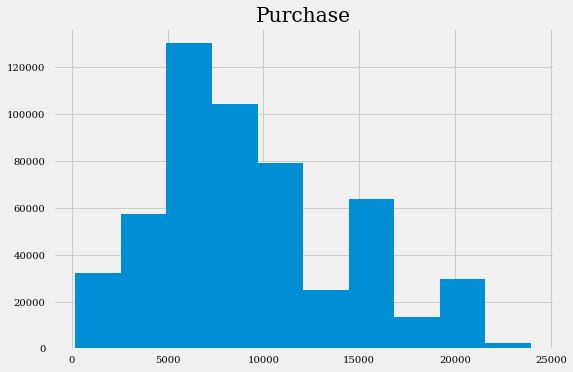

In [14]:
# Lets see how data is spread out before doing any preprocessing.
import matplotlib.style as style #style.available
#print(style.available)
#sns.set_style("whitegrid")
#sns.set_context("ggplot")

style.use('seaborn-notebook') #sets the size of the charts
style.use('fivethirtyeight')

_ = data.hist('Purchase', bins=10)
#plt.show()

# Most of the purchases are between 3000 and 12000 and around 16000 mark

<b>Comment: </b> The mean looks towards the left where as the distribution has a long right tail. 

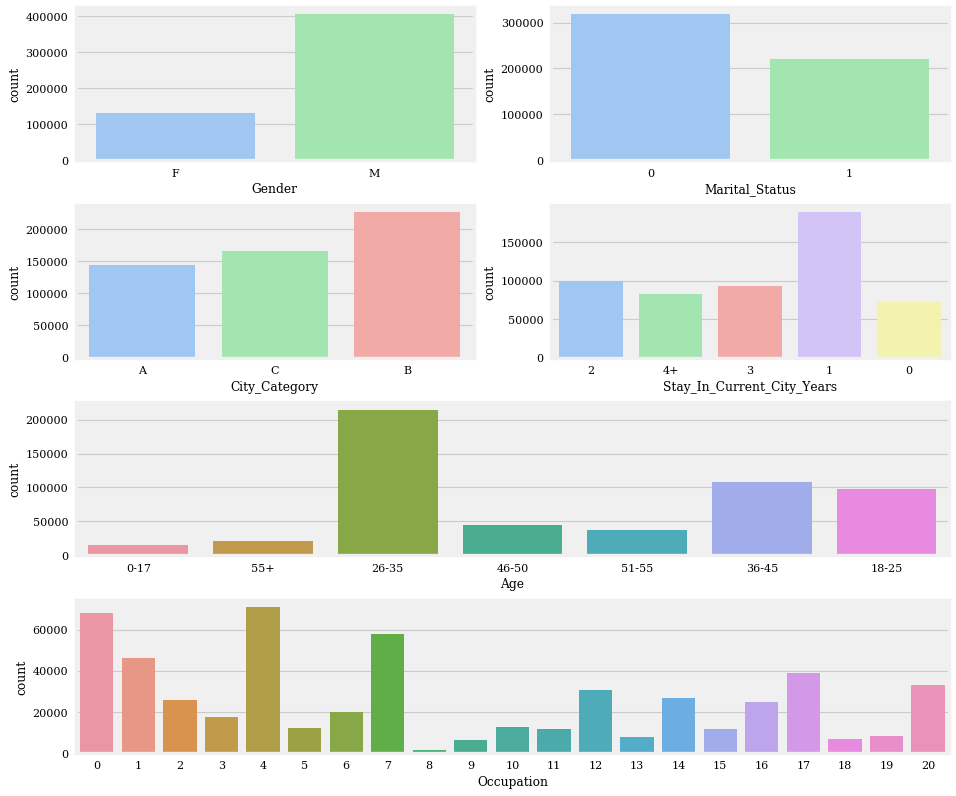

In [15]:
# Plot various histograms to see which variables could have a strong influence
# Take the count statistic first

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
#style.use('seaborn-paper') #sets the size of the charts
style.use('seaborn-notebook') #sets the size of the charts
style.use('seaborn-pastel') #set the style of the chart

fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4,2),(0,0))
ax1 = sns.countplot(data.Gender)
# for label in ax1.xaxis.get_ticklabels():
#     label.set_fontsize(8)
# for label in ax1.yaxis.get_ticklabels():
#     label.set_fontsize(8)

ax2 = plt.subplot2grid((4,2),(0,1))
ax2 = sns.countplot(data.Marital_Status)

ax3 = plt.subplot2grid((4,2),(1,0))
ax3 = sns.countplot(data.City_Category)

ax4 = plt.subplot2grid((4,2),(1,1))
ax4 = sns.countplot(data.Stay_In_Current_City_Years)

ax5 = plt.subplot2grid((4,2),(2,0), colspan=2)
ax5 = sns.countplot(data.Age)

ax6 = plt.subplot2grid((4,2),(3,0), colspan=2)
ax6 = sns.countplot(data.Occupation)
    
plt.tight_layout()

##### 2.1 Comments:
The above bar charts are purely counts of data elements from the set of ~537.5k rows and simply give and estimate about the number of observations in the set. They do not weigh towards the purchase amount and that analysis will be done later. This is what we can observe from the above charts:

1. Men shopped 3 times as much as women. This could be due to the fact that men paid for the purchases too.
2. Singles shopped more times than married ones.
3. Maximum number of purchases were made by people from City B, and people from cities A and C shop approximately the same number of times.
4. People who have been in the city for a year shop most frequently.
5. People between the age group of 26-35 shop the most followed by 36-45 and 18-25 groups
6. People in occupations 0,4,7 shop the most and 8 shop the least. 

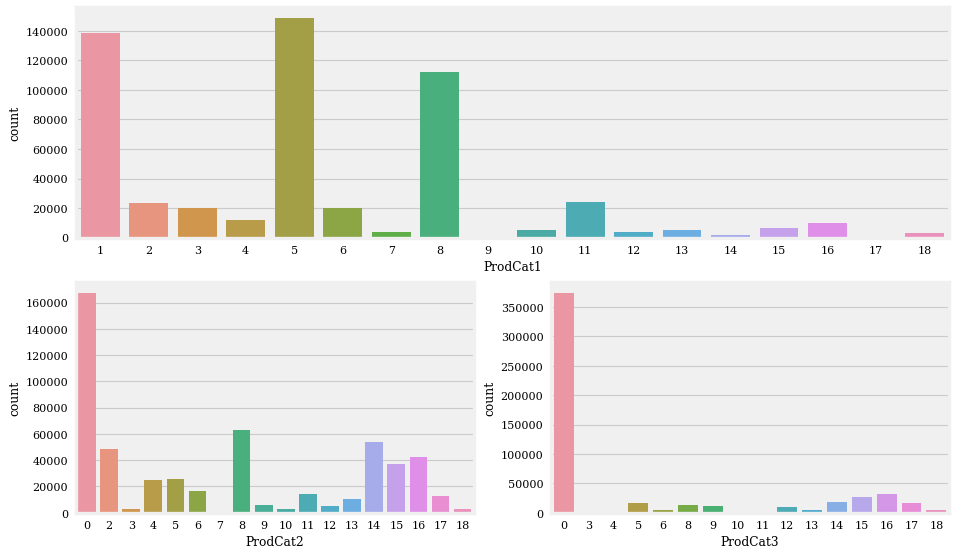

In [16]:
# Get the Product category distribution

style.use('seaborn-notebook') #sets the size of the charts
matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
fig = plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((2,2),(1,0))
ax1 = sns.countplot(data.ProdCat2)

ax2 = plt.subplot2grid((2,2),(1,1))
ax2 = sns.countplot(data.ProdCat3)

ax3 = plt.subplot2grid((2,2),(0,0), colspan=2)
ax3 = sns.countplot(data.ProdCat1)

plt.tight_layout()
#plt.subplots_adjust(left=0.9, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
#ax3.grid(True)



##### 2.2 Comments:
1. It can be seen that products 1,5 and 8 from Category 1 dominate the sales numbers by far and seem to be the favorites. 
2. There are a large number of products in Categories 2 and 3 that are either missing or not shopped for. Products in category 3 have very low numbers.
3. Although Category 2 is not all that popular, there are some products that seems to be popular. Such as 2,8,14 and 16. 

In [18]:
# Define a couple of functions to calculate the top_x and give a flattened view. My attempt to come up with something meaningful

def flatten(x):
    """ This function flattens the x-axis by inserting an underscore between its elements"""
    j=[]
    for multi_index in list(x):
        ele=[]
        if(str(type(multi_index))) =='<class \'tuple\'>':
            for i in list(multi_index):
                ele.append(str(i))
        else:
            ele.append(str(multi_index))
        j.append('_'.join(ele))
    return(j)

def top_x(df,sum_col,lst=[],top_n=5):
    """ Function returns the top n elements from a group by list, aggregated as sum by var(sum_col)"""
    y = df.groupby(lst)[sum_col].sum().to_frame().sort_values(by=sum_col, ascending=False)[:top_n]
    x = flatten(list(y.index))
    y = y.reset_index()
    y.index=x
    return y

# Example:
#y = top_x(data,'Purchase',['Gender','Occupation','Marital_Status','Age'],10)

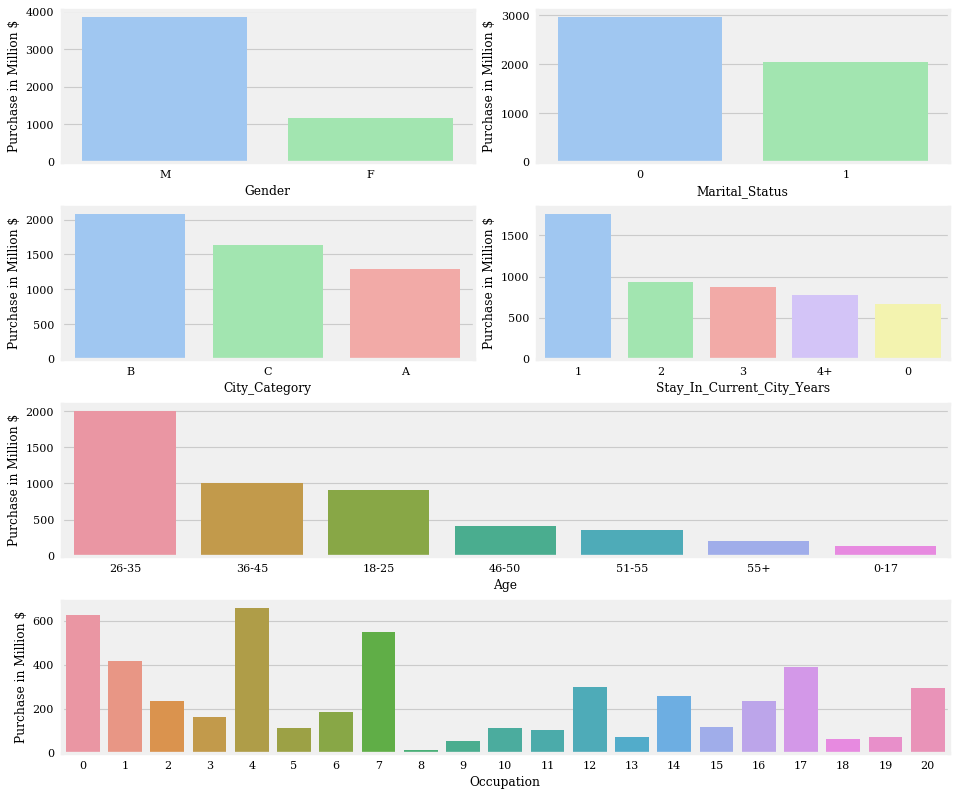

In [19]:
# Now lets look at how these variables influence on the total purchase value.

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-notebook') #sets the size of the charts
style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid((4,2),(0,0))
y = top_x(data,'Purchase',['Gender'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='Gender', data=y, estimator=sum, ci=None)
ax1.set(ylabel='Purchase in Million $')

ax2 = plt.subplot2grid((4,2),(0,1))
y = top_x(data,'Purchase',['Marital_Status'],5)
ax2 = sns.barplot(y=y.Purchase/1000000, x='Marital_Status', data=y, estimator=sum, ci=None)
ax2.set(ylabel='Purchase in Million $')

ax3 = plt.subplot2grid((4,2),(1,0))
y = top_x(data,'Purchase',['City_Category'],5)
ax3 = sns.barplot(y=y.Purchase/1000000, x='City_Category', data=y, estimator=sum, ci=None)
ax3.set(ylabel='Purchase in Million $')

ax4 = plt.subplot2grid((4,2),(1,1))
y = top_x(data,'Purchase',['Stay_In_Current_City_Years'],5)
ax4 = sns.barplot(y=y.Purchase/1000000, x='Stay_In_Current_City_Years', data=y, estimator=sum, ci=None)
ax4.set(ylabel='Purchase in Million $')

ax5 = plt.subplot2grid((4,2),(2,0), colspan=20)
y = top_x(data,'Purchase',['Age'],10)
ax5 = sns.barplot(y=y.Purchase/1000000, x='Age', data=y, estimator=sum, ci=None)
ax5.set(ylabel='Purchase in Million $')

ax6 = plt.subplot2grid((4,2),(3,0), colspan=2)
y = top_x(data,'Purchase',['Occupation'],24)
ax6 = sns.barplot(y=y.Purchase/1000000, x='Occupation', data=y, estimator=sum, ci=None)
ax6.set(ylabel='Purchase in Million $')

plt.tight_layout()
plt.show()  

##### 2.3 Comments:
Comparing this to the counts plots, it is now clear that the distribution in amounts is sort of similar to the distribution in counts. This means that we cannot see any variable disproportionately affecting the purchase. For example, it could have been possible that women bought all the expensive products and even though they shopped less number of times, they could have generated the most revenue. 
The two plots seems some what similar and we can conclude that no variable/distribution needs special attention.


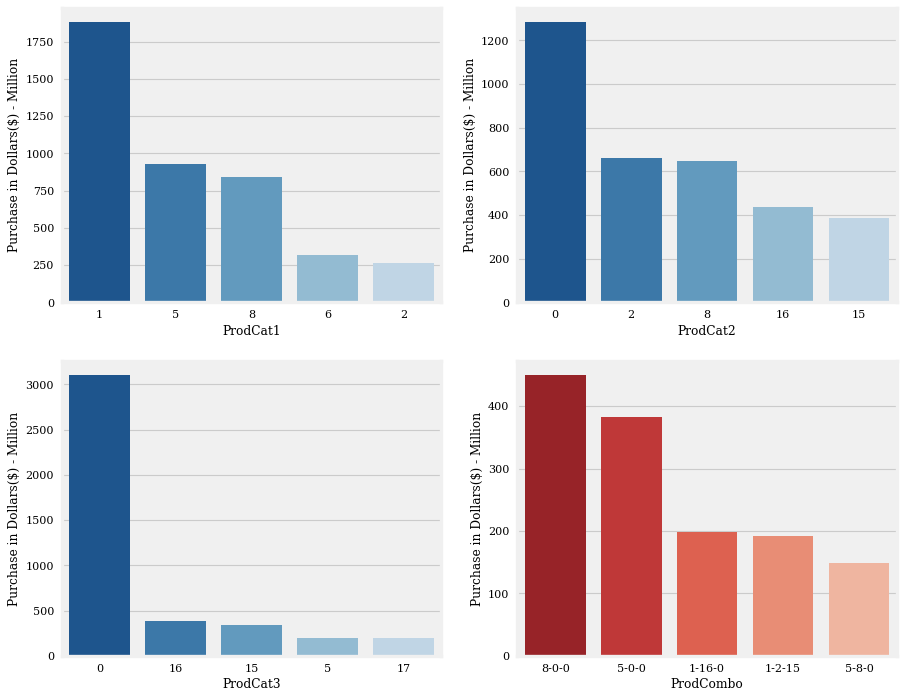

In [20]:
# Let us now have a look at which product Categories / combinations are top sellers

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-notebook') #sets the size of the charts
sns.set_palette("Blues_r")

#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid((2,2),(0,0))
y = top_x(data,'Purchase',['ProdCat1'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCat1', data=y, estimator=sum, ci=None, order=y.ProdCat1)
sns.color_palette=("Blues_d")
ax1.set(ylabel='Purchase in Dollars($) - Million')

ax1 = plt.subplot2grid((2,2),(0,1))
y = top_x(data,'Purchase',['ProdCat2'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCat2', data=y, estimator=sum, ci=None, order=y.ProdCat2)
ax1.set(ylabel='Purchase in Dollars($) - Million')

ax1 = plt.subplot2grid((2,2),(1,0))
y = top_x(data,'Purchase',['ProdCat3'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCat3', data=y, estimator=sum, ci=None, order=y.ProdCat3)
ax1.set(ylabel='Purchase in Dollars($) - Million')

sns.set_palette("Reds_r")
ax1 = plt.subplot2grid((2,2),(1,1))
y = top_x(data,'Purchase',['ProdCombo'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCombo', data=y, estimator=sum, ci=None, order=y.ProdCombo)
ax1.set(ylabel='Purchase in Dollars($) - Million')

plt.show()

##### 2.4 Comments:
By looking at the top revenue generators from products, it seems like it is a bit misleading when looking at isolated product categories. For example, it seems like product 1 is the most revenue generator overall from Category 1. And so are product 0 from Categories 2 and 3. However, the top revenue generator across the board is combination of product 8 from Category 1 and 0 from Categories 2 and 3 (i.e. 8-0-0). This also can be interpreted as product 1 from Category 1 is the top revenue generator, but it could be in combination with other products from Category 2 and 3. As you can see from the red graph that there are combinations of 1-16-0 and 1-2-15 in rank 3 & 4. There could be several other combinations which are not covered by the plots above. But product 8 from Category 1 is definitely the top revenue generator as Category 2 and 3 are 0 for it. 

In short, the ranking of ProdCombo columns needs to be looked at in conjunction with the ranking of individual ranking of product categories to derive any meaningful information from it. 

### Now lets start taking a deeper dive in to the data to figure out answers to questions such as:
 1. What are the characteristics of my top revenue generators
 2. Who buys the top product combinations

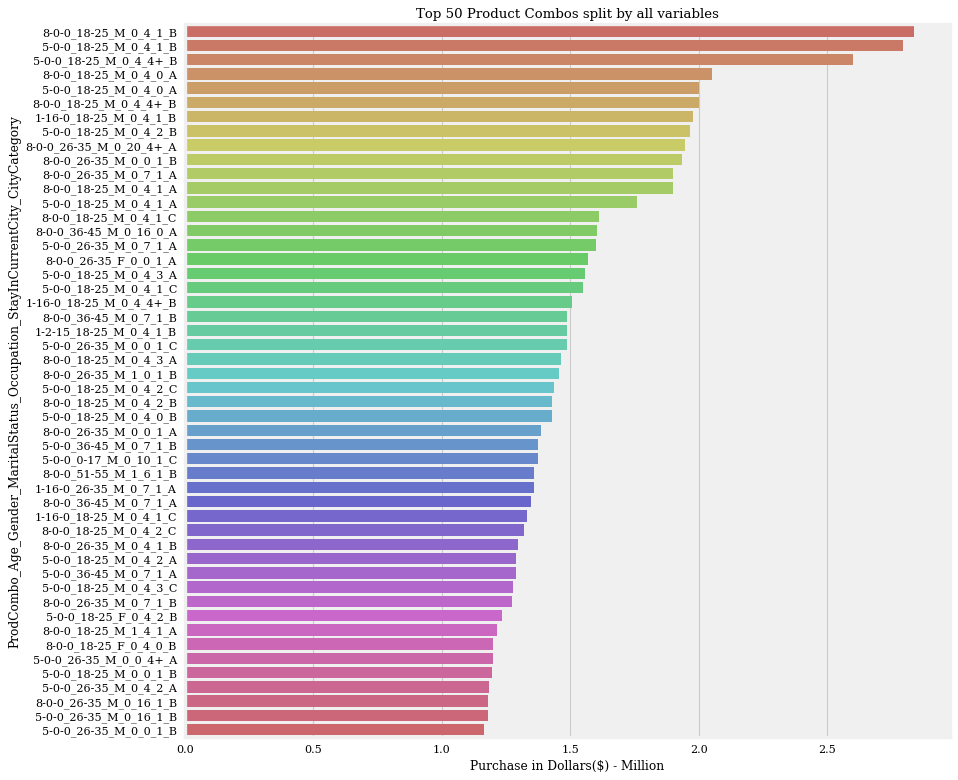

In [21]:
matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-notebook') #sets the size of the charts
#style.use('seaborn-pastel')
sns.set_palette("hls",50)

#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid((1,1),(0,0))
z = top_x(data,'Purchase',['ProdCombo','Age','Gender','Marital_Status','Occupation','Stay_In_Current_City_Years', 'City_Category'],50)
ax1 = sns.barplot(x=z.Purchase/1000000, y=z.index, data=z, estimator=sum, ci=None)
ax1.set(xlabel='Purchase in Dollars($) - Million')
ax1.set(ylabel='ProdCombo_Age_Gender_MaritalStatus_Occupation_StayInCurrentCity_CityCategory')
plt.title('Top 50 Product Combos split by all variables')

plt.show()

##### 2.5 Comments:
There is a lot to take in here. This plot is a master plot that shows all the Product combos that generate top revenue split by all parameters. It is worth nothing that although there are consistent top products, other variables such as Age, City etc. play a significant role. It is important to review the information here. It tell us a great deal, which we will need to process and aggregate this data to get meaningful insights. 

Lets explore these top 50 combos to see which variables influence it the most.

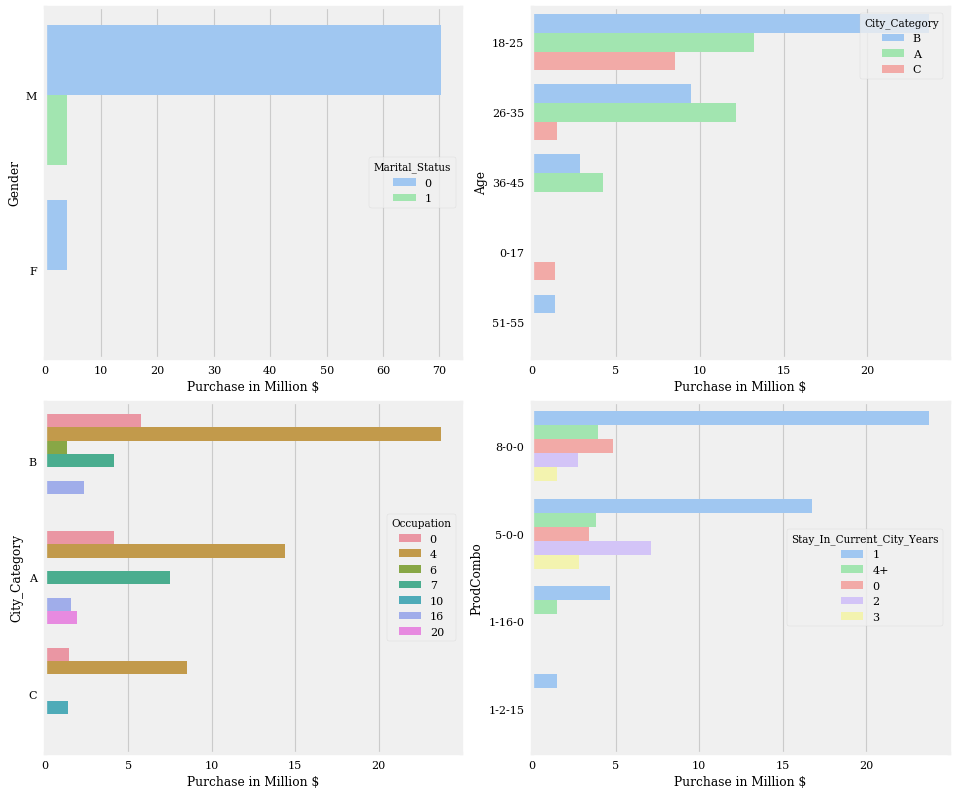

In [22]:
matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-pastel')
#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')


ax1 = plt.subplot2grid((2,2),(0,0))
ax1 = sns.barplot(x=z.Purchase/1000000, y=z['Gender'],  estimator=sum, hue=z['Marital_Status'], ci=None)
ax1.set(xlabel='Purchase in Million $')

ax2 = plt.subplot2grid((2,2),(0,1))
ax2 = sns.barplot(x=z.Purchase/1000000, y=z['Age'],  estimator=sum, hue=z['City_Category'], ci=None)
ax2.set(xlabel='Purchase in Million $')

ax3 = plt.subplot2grid((2,2),(1,0))
ax3 = sns.barplot(x=z.Purchase/1000000, y=z['City_Category'],  estimator=sum, hue=z['Occupation'], ci=None)
ax3.set(xlabel='Purchase in Million $')

ax4 = plt.subplot2grid((2,2),(1,1))
ax4 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCombo'],  estimator=sum, hue=z['Stay_In_Current_City_Years'], ci=None)
ax4.set(xlabel='Purchase in Million $')

plt.tight_layout()
plt.show()

##### 2.6 Comments:
The above analysis answers the question: <b> Who is my valuable/target audience? </b>

These conclusions can be made from the above plots:<br>
1. Single males buy the most
2. These single males are mainly from city B, in age group of 18-35. They are followed by city A in age groups of 18-25 and 25-36.
3. A disproportionate number of these people are in Occupation 4, mainly buying from city B and A.
4. People who mainly buy ProdCombos 8-0-0 and 5-0-0 have been living in the city around 1 year. 

<b>Conclusion:</b>
The target/valuable audience for Black Friday sale are single males from cities A and B in the age group of 18-35 in occupation 4 who have been living in their cities for around 1 year.

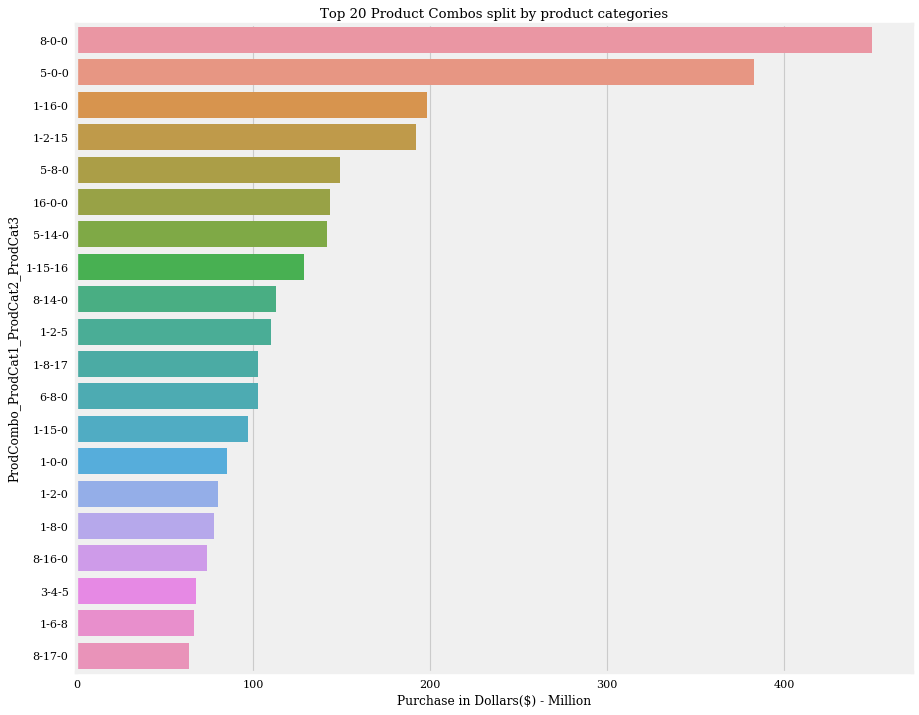

In [23]:
# Next we plot the top 20 combos so that we can analyze it in depth

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-pastel')
#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

z = top_x(data,'Purchase',['ProdCombo','ProdCat1','ProdCat2','ProdCat3'],20)
z['ProdCat1'] = z.ProdCat1.astype(str)
z['ProdCat2'] = z.ProdCat2.astype(str)
z['ProdCat3'] = z.ProdCat3.astype(str)

ax1 = sns.barplot(x=z.Purchase/1000000, y=z.ProdCombo, data=z, estimator=sum, ci=None)
ax1.set(xlabel='Purchase in Dollars($) - Million')
ax1.set(ylabel='ProdCombo_ProdCat1_ProdCat2_ProdCat3')
plt.title('Top 20 Product Combos split by product categories')

plt.show()

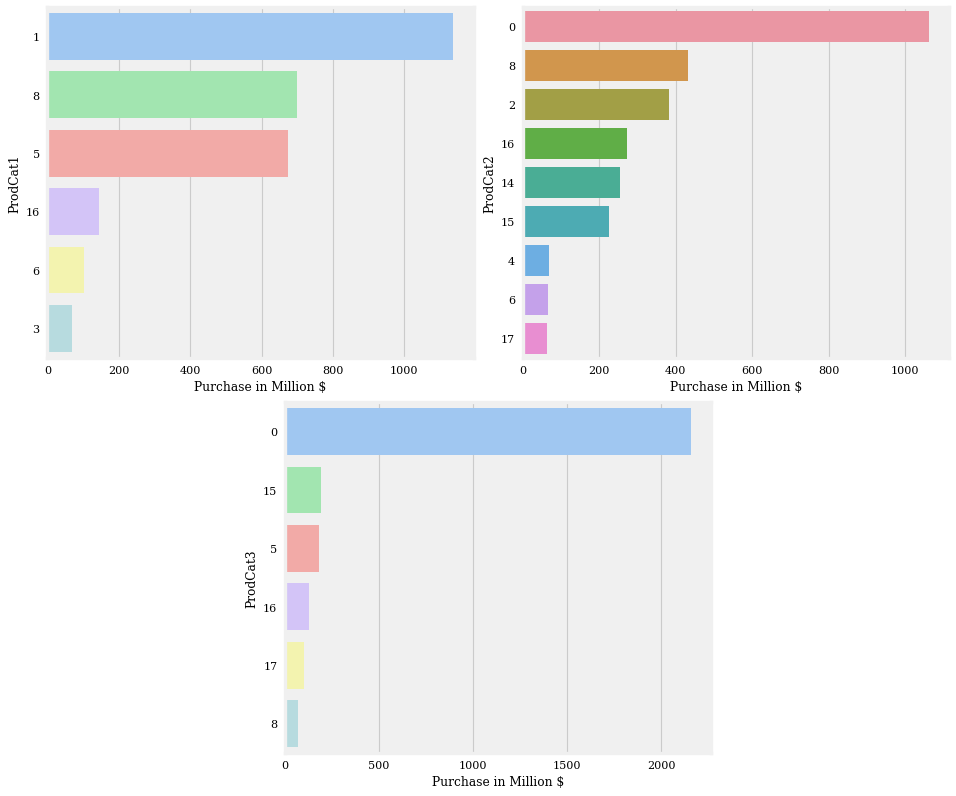

In [24]:
# Now we can compare which products from the top 20 combo get the most revenue.

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-pastel')
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')


ax1 = plt.subplot2grid((2,4),(0,0), colspan=2)
ax1 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCat1'], estimator=sum, orient='h', ci=None
                  , order=np.array(z.groupby('ProdCat1')['Purchase'].sum().sort_values(ascending=False).index))
ax1.set(xlabel='Purchase in Million $')


ax2 = plt.subplot2grid((2,4),(0,2), colspan=2)
ax2 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCat2'], estimator=sum, orient='h', ci=None
                  , order=np.array(z.groupby('ProdCat2')['Purchase'].sum().sort_values(ascending=False).index))
ax2.set(xlabel='Purchase in Million $')

ax3 = plt.subplot2grid((2,4),(1,1), colspan=2)
ax3 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCat3'], estimator=sum, orient='h', ci=None
                  , order=np.array(z.groupby('ProdCat3')['Purchase'].sum().sort_values(ascending=False).index))
ax3.set(xlabel='Purchase in Million $')

plt.tight_layout()
plt.show()

##### 2.7 Comments:
The above analysis attempts to answer this question: <b> Which are my top product categories and combos?</b>

In the top 20 combos, you can now confirm that product 1 in Category 1 still has the most number of combos and generates the highest revenue, followed by 8 and 5. In terms of combos across all three categories, 1-2-15, 1-15-16 and 1-2-5 are frequently bought together. Overall, assuming that these 3 categories hav independent products, the top products are:<br>
Category 1: 1,8,5<br>
Category 2: 8,2,16<br>
Category 3: 15,5,16<br>

### Step 3 - EDA - Search for correlations, significant variables and hypothesis testing

In [25]:
# Lets define a function for generating ecdf

from scipy import stats

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y



#### Question 1: Do men buy more expensive things than women?


C:\Users\Rishi\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


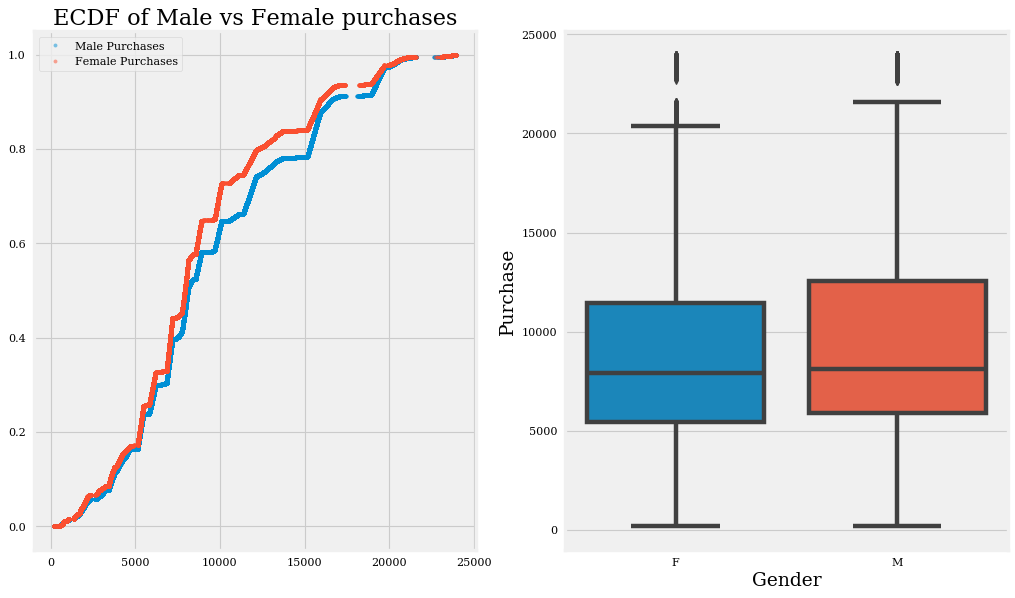

In [26]:
# Lets plot the ECDFs of the questions we are trying to answer.

style.use('seaborn-notebook') #sets the size of the charts
style.use('fivethirtyeight')

fig = plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((1,2),(0,0))
plt.title('ECDF of Male vs Female purchases')
#x , y = ecdf(data.Purchase)
#_ = ax1.plot(x, y, marker = '.', linestyle='none', label='Total population', alpha=0.5)

m_pur = data[data.Gender=='M'].Purchase
f_pur = data[data.Gender=='F'].Purchase

x , y = ecdf(m_pur)
_ = ax1.plot(x, y, marker = '.', linestyle='none', label='Male Purchases', alpha=0.5)

x , y = ecdf(f_pur)
_ = ax1.plot(x, y, marker = '.', linestyle='none', label = 'Female Purchases', alpha=0.5)
plt.legend()

ax2 = plt.subplot2grid((1,2),(0,1))
ax2 = sns.boxplot(x=data.Gender, y=data.Purchase)


plt.show()

<b>Comment:</b> It seems like men tend to make more expensive purchases by looking at ECDF. If an expensive purchase is defined as the one made with more than $10,000, then men in general seem to buy items with higher amounts. Also, as the data is large, a box plot is drawn. Here it can be seen that the median values are similar but the 75th percentile for men is higher than women. Let us see if this has any statistical significance.

<b>H0:</b> The average purchase price by men is the same as women for expensive items.<br>
<b>H1:</b> The average purchase price by men is more than women for expensive items. 


In [27]:
np.random.seed(35)
df = data[data.Purchase>=10000]
dfm = np.random.choice(df[(df.Gender=='M')].Purchase,10000)
dff = np.random.choice(df[(df.Gender=='F')].Purchase,10000)
print('Mean of men\'s purchase is: ',np.mean(dfm))
print('Mean of women\'s purchase is: ',np.mean(dff))
print('Mean of total purchase is: ',np.mean(df.Purchase))
mean_com = np.mean(df.Purchase)
obs_mean_diff = np.mean(dfm) - np.mean(dff)
z_tst_minus_obs = stats.norm.ppf(0.05)
z = obs_mean_diff / np.sqrt(np.square(dfm.std())/len(dfm) + np.square(dff.std())/len(dff))
p=stats.norm.cdf(-z) 
print('The probability that average purchases by men is equal to that of women is {:.3f}'.format(p))
print('This negates the null hypothesis.')

Mean of men's purchase is:  15068.7163
Mean of women's purchase is:  14931.9739
Mean of total purchase is:  15082.73146804466
The probability that average purchases by men is equal to that of women is 0.002
This negates the null hypothesis.


#### Question 2: Do people shop equally in all three cities?

C:\Users\Rishi\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


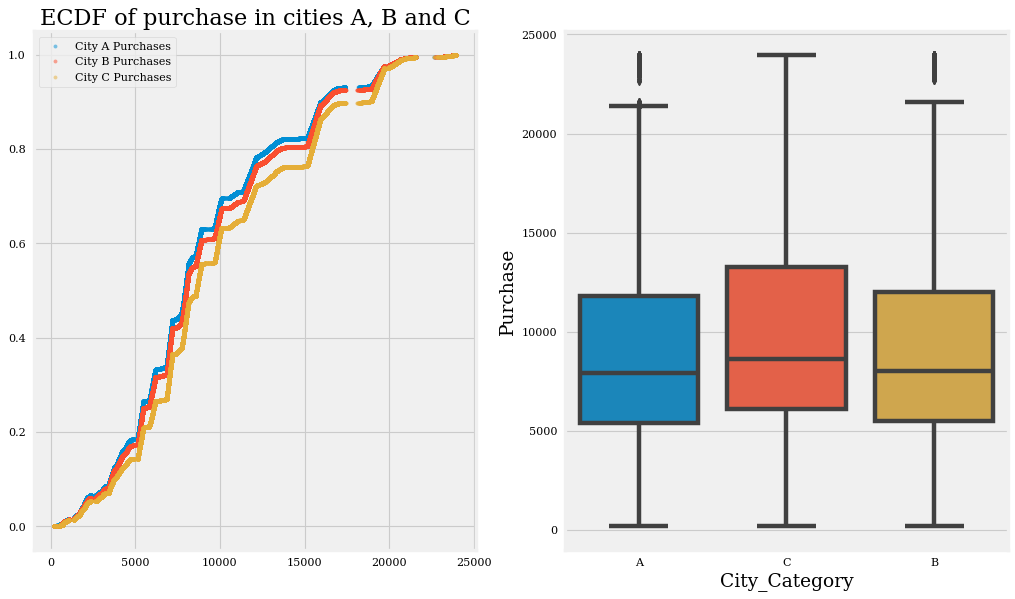

In [28]:
# Lets plot ECDF for second question

fig = plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((1,2),(0,0))
plt.title('ECDF of purchase in cities A, B and C')
a_pur = data[data.City_Category=='A'].Purchase
b_pur = data[data.City_Category=='B'].Purchase
c_pur = data[data.City_Category=='C'].Purchase

x , y = ecdf(a_pur)
_ = ax1.plot(x, y, marker = '.', linestyle='none', label='City A Purchases', alpha=0.5)

x , y = ecdf(b_pur)
_ = ax1.plot(x, y, marker = '.', linestyle='none', label='City B Purchases', alpha=0.5)

x , y = ecdf(c_pur)
_ = ax1.plot(x, y, marker = '.', linestyle='none', label = 'City C Purchases', alpha=0.5)
plt.legend()

ax2 = plt.subplot2grid((1,2),(0,1))
ax2 = sns.boxplot(x=data.City_Category, y=data.Purchase)

plt.show()

<b>Comments:</b> From the ECDF and box plots, we can see that in general people from city C generate more revenue. Whereas people from city A and B seems to have similar buying patterns. But does is mean people from city C also spend more? We will take the "Average Purchase value" as the measure for this. Lets see the statistical significance of this happening.

<b>H0:</b> The average purchase price by people in cities A, B and C is the same.<br>
<b>H1:</b> The average purchase price by people in cities A, B and C is NOT the same. 

In [29]:
dfa = data[(data.City_Category=='A')][:1000]
dfc = data[(data.City_Category=='C')][100:1100]
dfb = data[(data.City_Category=='B')][100:1100]
print('The mean purchase value by people from city A is: ',np.mean(dfa.Purchase))
print('The mean purchase value by people from city B is: ',np.mean(dfb.Purchase))
print('The mean purchase value by people from city C is: ',np.mean(dfc.Purchase))
mean_com = np.mean(df.Purchase)
obs_mean_diff_ac = np.mean(dfa.Purchase) - np.mean(dfc.Purchase)
obs_mean_diff_ab = np.mean(dfa.Purchase) - np.mean(dfb.Purchase)
obs_mean_diff_bc = np.mean(dfb.Purchase) - np.mean(dfc.Purchase)

z_ac = obs_mean_diff_ac / np.sqrt(np.square(dfa.Purchase.std())/len(dfa.Purchase) + np.square(dfc.Purchase.std())/len(dfc.Purchase))
print('The probability that average purchases from City A are equal to City C are: {:.3f}'.format(stats.norm.cdf(z_ac)))

z_ab = obs_mean_diff_ab / np.sqrt(np.square(dfa.Purchase.std())/len(dfa.Purchase) + np.square(dfb.Purchase.std())/len(dfb.Purchase))
print('The probability that average purchases from City A are equal to City B are: {:.3f}'.format(stats.norm.cdf(z_ab)))

z_bc = obs_mean_diff_bc / np.sqrt(np.square(dfb.Purchase.std())/len(dfb.Purchase) + np.square(dfc.Purchase.std())/len(dfc.Purchase))
print('The probability that average purchases from City B are equal to City C are: {:.3f}'.format(stats.norm.cdf(z_bc)))
print('This negates the null hypothesis.')

The mean purchase value by people from city A is:  9131.392
The mean purchase value by people from city B is:  9366.509
The mean purchase value by people from city C is:  9792.204
The probability that average purchases from City A are equal to City C are: 0.001
The probability that average purchases from City A are equal to City B are: 0.141
The probability that average purchases from City B are equal to City C are: 0.028
This negates the null hypothesis.


#### Correlations
Let us now explore if there are any correlations in the variables. In order to do that, we will need to have varibles in number format.

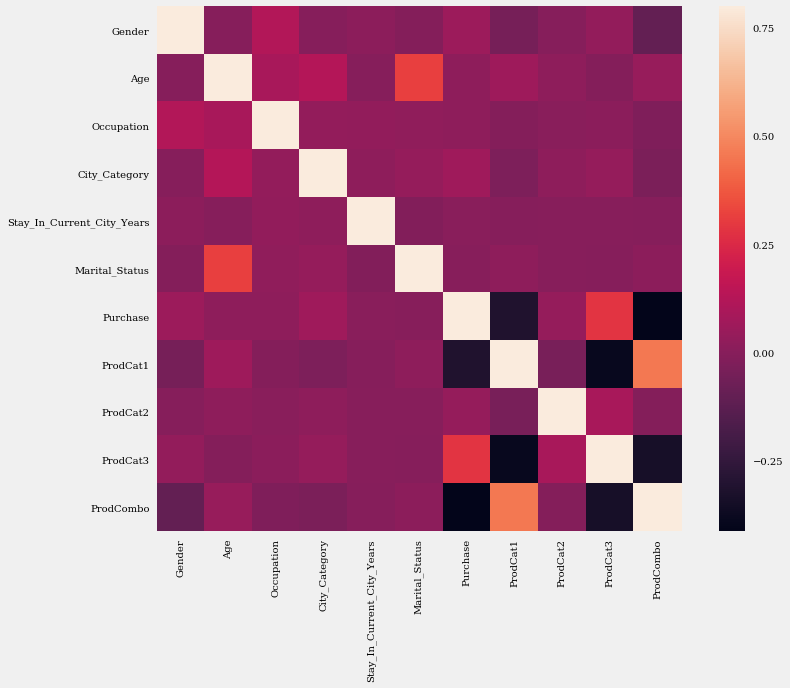

In [31]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# data=data_bkup[:]
le = LabelEncoder()
df = data.drop(['User_ID', 'Product_ID'], axis=1) # drop User_ID and Product_ID
df['Age'] = le.fit_transform(df.Age)
df['Gender'] = le.fit_transform(df.Gender)
df['City_Category'] = le.fit_transform(df.City_Category)
df['ProdCombo'] = le.fit_transform(df.ProdCombo)
df['Stay_In_Current_City_Years'] = le.fit_transform(df.Stay_In_Current_City_Years)
corrmat = df.corr()
fig,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

<b>Comment:</b> Marital status seems to have strong positive correlation with Age. And ProdCat1 seems to be strongly correlated with ProdCombo, but this does not mean much. It could be possible that there are a lot of products from Category1 in ProdCombo column. There is slight negative correlation between Purchase and ProdCat3 and ProdCombo, which means there are a lot fewer items of category 3. Other than that, there doesn't seems to be any strong correlation between the variables. 



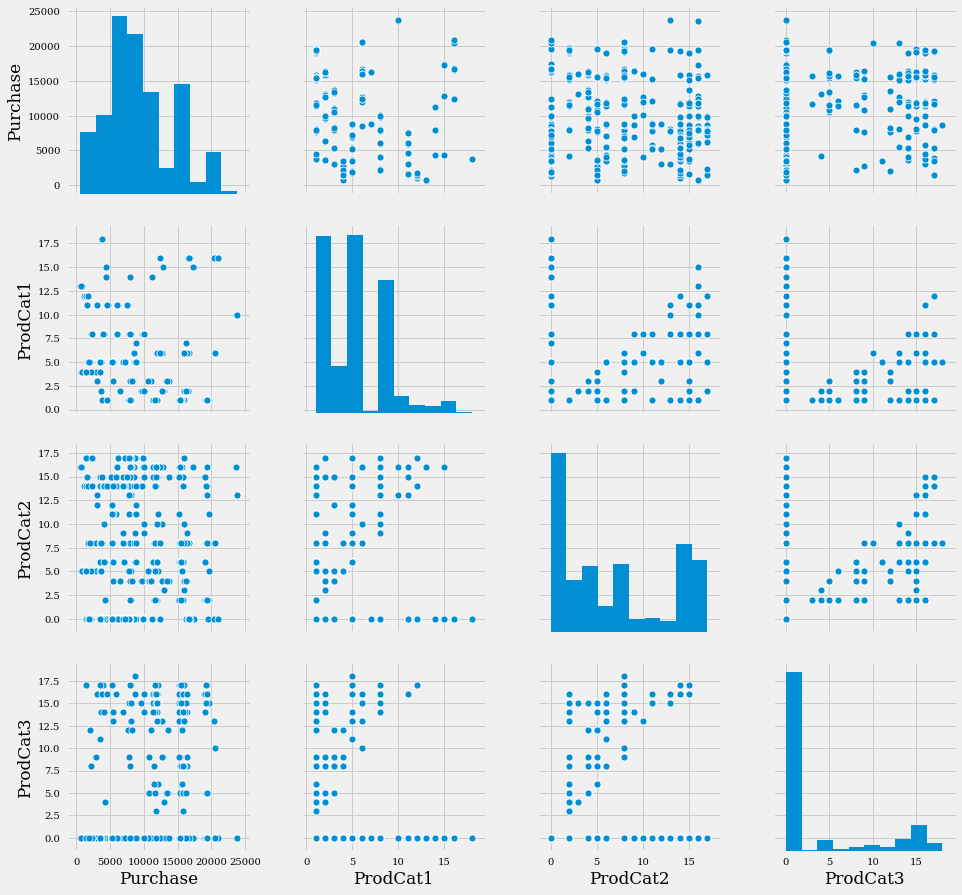

In [32]:
# plt.rcParams['figure.figsize']=(14,14)
g = sns.pairplot(data[['Purchase','ProdCat1','ProdCat2','ProdCat3']][:500])
g.fig.set_size_inches(14,13)


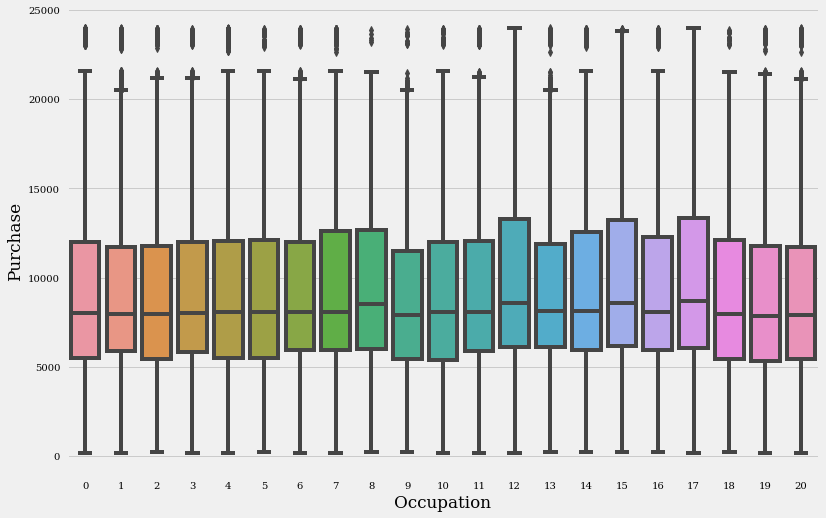

In [33]:
plt.rcParams['figure.figsize']=(12,8)
g = sns.boxplot(data['Occupation'], data.Purchase)


### Step 4 - Data Preprocessing and model building

### Approach 1 - Traditional

In [34]:
# Take back up of the data frame
data_bkup = data[:]

In [35]:
# Data Preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Prepare encoding of categorical variables
# data['Gender_enc'] = data.Gender.apply(lambda x: 1 if x=='M' else 0)
data['Gender_enc'] = pd.get_dummies(data.Gender, drop_first=True)
age = pd.get_dummies(data.Age, columns=['Age_'], drop_first=True)
age.columns = 'Age_' + age.columns.astype(str)
age.columns = age.columns.str.replace('+','')
city = pd.get_dummies(data.City_Category, drop_first=True)
city.columns = 'City_' + city.columns
stay =  pd.get_dummies(data.Stay_In_Current_City_Years, drop_first=True)
stay.columns = 'stay' + stay.columns
stay.columns = stay.columns.str.replace('+','')
occu = pd.get_dummies(data.Occupation, drop_first=True)
occu.columns = 'occu' + occu.columns.astype(str)
pc = pd.get_dummies(data.ProdCombo, drop_first=True)
pc.columns = 'pc_' + pc.columns.astype(str)
pc1 = pd.get_dummies(data.ProdCat1, drop_first=True)
pc1.columns = 'pc1_' + pc1.columns.astype(str)
pc2 = pd.get_dummies(data.ProdCat2, drop_first=True)
pc2.columns = 'pc2_' + pc2.columns.astype(str)
pc3 = pd.get_dummies(data.ProdCat3, drop_first=True)
pc3.columns = 'pc3_' + pc3.columns.astype(str)

In [47]:
# Look at the columns for data
# with pd.option_context('display.height', 1000, 'display.max_rows', 500, 'display.max_columns', 500, 'display.width', 1000):
print(list(data.columns))
print(list(age.columns))
print(list(city.columns))
print(list(stay.columns))
print(list(occu.columns))
print(list(pc.columns))
print(list(pc1.columns))
print(list(pc2.columns))
print(list(pc3.columns))


['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Purchase', 'ProdCat1', 'ProdCat2', 'ProdCat3', 'ProdCombo', 'Age_Avgpv', 'Stay_Avgpv', 'Occu_Avgpv', 'City_Avgpv', 'Gen_Avgpv', 'User_Avgpv', 'Pc1_Avgpv', 'PID_Avgpv', 'PC_Avgpv', 'Pc2_Avgpv', 'Age_cnts', 'Stay_cnts', 'Occu_cnts', 'City_cnts', 'Gen_cnts', 'User_cnts', 'Pc1_cnts', 'PID_cnts', 'PC_cnts', 'Pc2_cnts', 'Age_avgcnt', 'Stay_avgcnt', 'Occu_avgcnt', 'City_avgcnt', 'Gen_avgcnt', 'User_avgcnt', 'Pc1_avgcnt', 'PID_avgcnt', 'PC_avgcnt', 'Pc2_avgcnt', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase', 'Purchase']
['Age_18-25', 'Age_26-35', 'Age_36-45', 'Age_46-50', 'Age_51-55', 'Age_55']
['City_B', 'City_C']
['stay1', 'stay2', 'stay3', 'stay4']
['occu1', 'occu2', 'occu3', 'occu4', 'occu5', 'occu6', 'occu7', 'occ

In [37]:
# Do regression without the ProdCombo column to check the accuracy 
# Use train test split and also cross validation to see what scores you get

data = pd.concat([data, age, city, stay, occu], axis=1)
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=42)

reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 without ProdCombo: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error without ProdCombo: {}".format(rmse))
cv = cross_val_score(reg, X, y, cv=5)
print('Cross validation score  without ProdCombo is: {}'.format(np.mean(cv)))

R^2 without ProdCombo: 0.01206536443227857
Root Mean Squared Error without ProdCombo: 4953.181270547325
Cross validation score  without ProdCombo is: 0.011313071286962595


<b>Comment:</b> As you can see, the model works very poorly. Now lets try to add the prod combo columns and see if it is any different.

In [38]:
data = data_bkup[:] # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc], axis=1) # Include the pc (ProdCombo) column
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]

# try with random_state=40
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=40)
reg = LinearRegression() 
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 with ProdCombo with random_state=40: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error with ProdCombo and with random_state=40: {}".format(rmse))
cv = cross_val_score(reg, X, y, cv=5)
print('Cross validation score is with ProdCombo and with random_state=40: {}\n'.format(np.mean(cv)))

# try with random_state=4
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)
reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 with ProdCombo with random_state=4: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error with ProdCombo and with random_state=4: {}".format(rmse))
cv = cross_val_score(reg, X, y, cv=5)
print('Cross validation score is with ProdCombo and with random_state=4: {}'.format(np.mean(cv)))

R^2 with ProdCombo with random_state=40: 0.655699455601756
Root Mean Squared Error with ProdCombo and with random_state=40: 2922.1222065032102
Cross validation score is with ProdCombo and with random_state=40: -2.341431538004935e+17

R^2 with ProdCombo with random_state=4: 0.651243441952867
Root Mean Squared Error with ProdCombo and with random_state=4: 2932.718333174482
Cross validation score is with ProdCombo and with random_state=4: -2.341431538004935e+17


<b>Comment:</b> The model seems to have good accuracy at first with $R^2$ = 0.655 with random_state=40. But this is highly misleading. Look at how big the cross-validation score is. This means something is not right and there are values which throw it off. May be we got good accuracy by chance, by the way the data fell in place. To prove this, lets set the random_state to 4 and see the results. They give away the "luck of the draw" we had when we chose the random_state. Now even the first $R^2$ is a bigger number. So overall, even this does not seem to be a good choice of variables. 

Now lets try with individual Product Category columns to see if it is better to pass those values. Afterall, there are 235 distinct product combinations whereas there are 18, 18 and 16 product categories in type 1, 2 and 3 respectively. Meaning there are less number of columns in comparison to ProdCombo $(18 + 18 + 16 < 235)$.

In [57]:
# Now lets try to add the prodcat* columns and see if it is any different.

data = data_bkup[:] # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc1, pc2, pc3], axis=1) # Include the pc (ProdCombo) column
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)
reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 with Prod Categories: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error with Prod Categories: {}".format(rmse))
cv = cross_val_score(reg, X, y, cv=5)
print('Cross validation score is with Prod Categories: {}'.format(np.mean(cv)))

R^2 with Prod Categories: 0.6376223400425602
Root Mean Squared Error with Prod Categories: 2989.4402029238413
Cross validation score is with Prod Categories: 0.6389821282926864


<b>Comment:</b> Now this seems to be a good choice of variables in the model. $R^2$ is consistent in cross-validation. Now lets apply these set of variables to different models to see if we can increase this accuracy.

But before we do that, lets try to see if we can reduce the number of variables whilst maintaining accuracy. This will tell us the significance of those variables as well as possibility of a leaner model.

In [59]:
# # Now lets try to see if we can take out some more variables.

# Take out age
data = data_bkup[:]
data = pd.concat([data, city, stay, occu, pc1, pc2, pc3 ], axis=1)
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)
reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 WITHOUT Age: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error WITHOUT Age: {}\n".format(rmse))

# Take out occupation
data = data_bkup[:]
data = pd.concat([data, city, stay, pc1, pc2, pc3 ], axis=1)
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)
reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 WITHOUT Occupation: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error WITHOUT Occupation: {}\n".format(rmse))

# Take out product categories 2 and 3
data = data_bkup[:]
data = pd.concat([data, city, stay, pc1], axis=1)
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)
reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 WITHOUT Product Categories 2 & 3: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error WITHOUT Product Categories 2 & 3: {}\n".format(rmse))

# Take out city, stay and also drop 'Marital_Status' and 'Gender_enc' columns
data = data_bkup[:]
data = pd.concat([data, pc1], axis=1)
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=40)
reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2 ONLY with PC1: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error ONLY with PC1: {}".format(rmse))


R^2 WITHOUT Age: 0.6371668278319123
Root Mean Squared Error WITHOUT Age: 2991.318490424371

R^2 WITHOUT Occupation: 0.6364751755620913
Root Mean Squared Error WITHOUT Occupation: 2994.1682397495524

R^2 WITHOUT Product Categories 2 & 3: 0.6287018464866256
Root Mean Squared Error WITHOUT Product Categories 2 & 3: 3026.011382911443

R^2 ONLY with PC1: 0.6306038606753479
Root Mean Squared Error ONLY with PC1: 3026.7440410567406


<b>Comment:</b> It can be seen that the single most significant predictor is Product Cateogory 1, which give an accuracy close to 0.63 by itself.

One can debate whether other variables are needed or not. But since we have it, lets try out whether any other variable reduction technique works. Like PCA

In [61]:
%%time
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100, random_state=0)
# DT = DecisionTreeRegressor(random_state=0)
data = data_bkup[:] # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc1, pc2, pc3], axis=1) 
# data = pd.concat([data, age1, city, stay, occu1, pc11, pc21, pc31], axis=1) 

drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)
DT.fit(train_X, train_y)

pred_y = DT.predict(test_X)

print("R^2: {}".format(DT.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.635121867047957
Root Mean Squared Error: 2999.736317822526
Wall time: 5.83 s


In [63]:
%%time

# Use Elastic CV to tune 

from sklearn.linear_model import ElasticNetCV
LCV = ElasticNetCV(random_state=40, cv=5, alphas=np.linspace(0.001,1,50))
# data = data_bkup[:] # reset the data column set
# usr.columns = 'usr_' + usr.columns.astype(str)
# data = pd.concat([data, age, city, stay, occu, pc1], axis=1) 

# drop_cols = ['User_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)#[:100000]
y = data[['Purchase']]#[:100000]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=45)
LCV.fit(train_X,train_y.Purchase)

pred_y = LCV.predict(test_X)

print("R^2: {}".format(LCV.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6400716117954796
Root Mean Squared Error: 2993.6060388057804
Wall time: 35.8 s


In [54]:
%%time

## Not good on FULL Dataset. Include in your project for tries.

from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(max_depth=16, n_estimators=90, random_state=0)
# RF = RandomForestRegressor(random_state=0)
data = data_bkup # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc1, pc2, pc3], axis=1) 
drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category','Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data.Purchase
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=45)
RF.fit(train_X, train_y)

pred_y = RF.predict(test_X)

print("R^2: {}".format(RF.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6424529101374172
Root Mean Squared Error: 2983.686705716457
Wall time: 5min 20s


<b>Comment</b> In general we are not getting past the 0.65 accuracy mark. Lets try some feature engineering to improve the scores.

********************************************************************

In [55]:
# Define the feature engineering functions

def avg_pv(df, col, num):
    """ This function calculates the average purchase value, given the column"""
    total = df.groupby(col)[num].sum()
    cnt = df.groupby(col)[num].count()
    avg = pd.DataFrame((cnt/cnt.sum()) * total)
    df_ext = df[[col]].join(avg, on=col).sort_index()
    return(df_ext)

def avg_cnt(df, col, num):
    """ This function calculates the average count, given the column"""
#     total = df.groupby(col)[num].sum()
    cnt = df.groupby(col)[num].count()
    avg = pd.DataFrame((cnt/cnt.sum()))
    df_ext = df[[col]].join(avg, on=col).sort_index()
    return(df_ext)

def cnts(df, col, num):
    """ This function calculates the total counts, given the column"""
    cnt = df.groupby(col)[num].count()
    tot = pd.DataFrame(cnt)
    df_ext = df[[col]].join(tot, on=col).sort_index()
    return(df_ext)

def med(df, col, num):
    """ This function calculates the median purchase value, given the column"""
    med = df.groupby(col)[num].median()
    tot = pd.DataFrame(med)
    df_ext = df[[col]].join(tot, on=col).sort_index()
    return(df_ext)

In [56]:
# Use these functions to calculate the Average Purchase Value = Total Purchase value / Number of items in that group.

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
pid = BF[['Product_ID']]
data = data_bkup[:]

age_avgpv = avg_pv(data, 'Age', 'Purchase')[['Purchase']]
age_avgpv_ss = ss.fit_transform(age_avgpv)
age_avgpv_ss = pd.DataFrame(age_avgpv_ss, columns=['Age_Avgpv'])

occu_avgpv = avg_pv(data, 'Occupation', 'Purchase')[['Purchase']]
occu_avgpv_ss = ss.fit_transform(occu_avgpv)
occu_avgpv_ss = pd.DataFrame(occu_avgpv_ss, columns=['Occu_Avgpv'])

stay_avgpv = avg_pv(data, 'Stay_In_Current_City_Years', 'Purchase')[['Purchase']]
stay_avgpv_ss = ss.fit_transform(stay_avgpv)
stay_avgpv_ss = pd.DataFrame(stay_avgpv_ss, columns=['Stay_Avgpv'])

pc1_avgpv = avg_pv(data, 'ProdCat1', 'Purchase')[['Purchase']]
pc1_avgpv_ss = ss.fit_transform(pc1_avgpv)
pc1_avgpv_ss = pd.DataFrame(pc1_avgpv_ss, columns=['Pc1_Avgpv'])

pc2_avgpv = avg_pv(data, 'ProdCat2', 'Purchase')[['Purchase']]
pc2_avgpv_ss = ss.fit_transform(pc2_avgpv)
pc2_avgpv_ss = pd.DataFrame(pc2_avgpv_ss, columns=['Pc2_Avgpv'])

pc3_avgpv = avg_pv(data, 'ProdCat3', 'Purchase')[['Purchase']]
pc3_avgpv_ss = ss.fit_transform(pc3_avgpv)
pc3_avgpv_ss = pd.DataFrame(pc3_avgpv_ss, columns=['Pc3_Avgpv'])

gen_avgpv = avg_pv(data, 'Gender', 'Purchase')[['Purchase']]
gen_avgpv_ss = ss.fit_transform(gen_avgpv)
gen_avgpv_ss = pd.DataFrame(gen_avgpv_ss, columns=['Gen_Avgpv'])

city_avgpv = avg_pv(data, 'City_Category', 'Purchase')[['Purchase']]
city_avgpv_ss = ss.fit_transform(city_avgpv)
city_avgpv_ss = pd.DataFrame(city_avgpv_ss, columns=['City_Avgpv'])

pc_avgpv = avg_pv(data, 'ProdCombo', 'Purchase')[['Purchase']]
pc_avgpv_ss = ss.fit_transform(pc_avgpv)
pc_avgpv_ss = pd.DataFrame(pc_avgpv_ss, columns=['PC_Avgpv'])

usr_avgpv = avg_pv(data, 'User_ID', 'Purchase')[['Purchase']]
usr_avgpv_ss = ss.fit_transform(usr_avgpv)
usr_avgpv_ss = pd.DataFrame(usr_avgpv_ss, columns=['User_Avgpv'])

pid_avgpv = avg_pv(BF, 'Product_ID', 'Purchase')[['Purchase']]
pid_avgpv_ss = ss.fit_transform(pid_avgpv)
pid_avgpv_ss = pd.DataFrame(pid_avgpv_ss, columns=['PID_Avgpv'])


In [57]:
# Use these functions to calculate the total count of data items for that group.

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

age_cnts = cnts(data, 'Age', 'Purchase')[['Purchase']]
age_cnts_ss = ss.fit_transform(age_cnts)
age_cnts_ss = pd.DataFrame(age_cnts_ss, columns=['Age_cnts'])

occu_cnts = cnts(data, 'Occupation', 'Purchase')[['Purchase']]
occu_cnts_ss = ss.fit_transform(occu_cnts)
occu_cnts_ss = pd.DataFrame(occu_cnts_ss, columns=['Occu_cnts'])

stay_cnts = cnts(data, 'Stay_In_Current_City_Years', 'Purchase')[['Purchase']]
stay_cnts_ss = ss.fit_transform(stay_cnts)
stay_cnts_ss = pd.DataFrame(stay_cnts_ss, columns=['Stay_cnts'])

pc1_cnts = cnts(data, 'ProdCat1', 'Purchase')[['Purchase']]
pc1_cnts_ss = ss.fit_transform(pc1_cnts)
pc1_cnts_ss = pd.DataFrame(pc1_cnts_ss, columns=['Pc1_cnts'])

pc2_cnts = cnts(data, 'ProdCat2', 'Purchase')[['Purchase']]
pc2_cnts_ss = ss.fit_transform(pc2_cnts)
pc2_cnts_ss = pd.DataFrame(pc2_cnts_ss, columns=['Pc2_cnts'])

pc3_cnts = cnts(data, 'ProdCat3', 'Purchase')[['Purchase']]
pc3_cnts_ss = ss.fit_transform(pc3_cnts)
pc3_cnts_ss = pd.DataFrame(pc3_cnts_ss, columns=['Pc3_cnts'])

gen_cnts = cnts(data, 'Gender', 'Purchase')[['Purchase']]
gen_cnts_ss = ss.fit_transform(gen_cnts)
gen_cnts_ss = pd.DataFrame(gen_cnts_ss, columns=['Gen_cnts'])

city_cnts = cnts(data, 'City_Category', 'Purchase')[['Purchase']]
city_cnts_ss = ss.fit_transform(city_cnts)
city_cnts_ss = pd.DataFrame(city_cnts_ss, columns=['City_cnts'])

pc_cnts = cnts(data, 'ProdCombo', 'Purchase')[['Purchase']]
pc_cnts_ss = ss.fit_transform(pc_cnts)
pc_cnts_ss = pd.DataFrame(pc_cnts_ss, columns=['PC_cnts'])

usr_cnts = cnts(data, 'User_ID', 'Purchase')[['Purchase']]
usr_cnts_ss = ss.fit_transform(usr_cnts)
usr_cnts_ss = pd.DataFrame(usr_cnts_ss, columns=['User_cnts'])

pid_cnts = cnts(BF, 'Product_ID', 'Purchase')[['Purchase']]
pid_cnts_ss = ss.fit_transform(pid_cnts)
pid_cnts_ss = pd.DataFrame(pid_cnts_ss, columns=['PID_cnts'])


In [58]:
# Use these functions to calculate the median items for that group.

age_med = med(data, 'Age', 'Purchase')[['Purchase']]
age_med_ss = ss.fit_transform(age_med)
age_med_ss = pd.DataFrame(age_med_ss, columns=['Age_med'])

occu_med = med(data, 'Occupation', 'Purchase')[['Purchase']]
occu_med_ss = ss.fit_transform(occu_med)
occu_med_ss = pd.DataFrame(occu_med_ss, columns=['Occu_med'])

stay_med = med(data, 'Stay_In_Current_City_Years', 'Purchase')[['Purchase']]
stay_med_ss = ss.fit_transform(stay_med)
stay_med_ss = pd.DataFrame(stay_med_ss, columns=['Stay_med'])

pc1_med = med(data, 'ProdCat1', 'Purchase')[['Purchase']]
pc1_med_ss = ss.fit_transform(pc1_med)
pc1_med_ss = pd.DataFrame(pc1_med_ss, columns=['Pc1_med'])

pc2_med = med(data, 'ProdCat2', 'Purchase')[['Purchase']]
pc2_med_ss = ss.fit_transform(pc2_med)
pc2_med_ss = pd.DataFrame(pc2_med_ss, columns=['Pc2_med'])

pc3_med = med(data, 'ProdCat3', 'Purchase')[['Purchase']]
pc3_med_ss = ss.fit_transform(pc3_med)
pc3_med_ss = pd.DataFrame(pc3_med_ss, columns=['Pc3_med'])

gen_med = med(data, 'Gender', 'Purchase')[['Purchase']]
gen_med_ss = ss.fit_transform(gen_med)
gen_med_ss = pd.DataFrame(gen_med_ss, columns=['Gen_med'])

city_med = med(data, 'City_Category', 'Purchase')[['Purchase']]
city_med_ss = ss.fit_transform(city_med)
city_med_ss = pd.DataFrame(city_med_ss, columns=['City_med'])

pc_med = med(data, 'ProdCombo', 'Purchase')[['Purchase']]
pc_med_ss = ss.fit_transform(pc_med)
pc_med_ss = pd.DataFrame(pc_med_ss, columns=['PC_med'])

usr_med = med(data, 'User_ID', 'Purchase')[['Purchase']]
usr_med_ss = ss.fit_transform(usr_med)
usr_med_ss = pd.DataFrame(usr_med_ss, columns=['User_med'])

pid_med = med(BF, 'Product_ID', 'Purchase')[['Purchase']]
pid_med_ss = ss.fit_transform(pid_med)
pid_med_ss = pd.DataFrame(pid_med_ss, columns=['PID_med'])

In [59]:
# Use these functions to calculate the average count of items for that group.

age_avgcnt = avg_cnt(data, 'Age', 'Purchase')[['Purchase']]
age_avgcnt_ss = ss.fit_transform(age_avgcnt)
age_avgcnt_ss = pd.DataFrame(age_avgcnt_ss, columns=['Age_avgcnt'])

occu_avgcnt = avg_cnt(data, 'Occupation', 'Purchase')[['Purchase']]
occu_avgcnt_ss = ss.fit_transform(occu_avgcnt)
occu_avgcnt_ss = pd.DataFrame(occu_avgcnt_ss, columns=['Occu_avgcnt'])

stay_avgcnt = avg_cnt(data, 'Stay_In_Current_City_Years', 'Purchase')[['Purchase']]
stay_avgcnt_ss = ss.fit_transform(stay_avgcnt)
stay_avgcnt_ss = pd.DataFrame(stay_avgcnt_ss, columns=['Stay_avgcnt'])

pc1_avgcnt = avg_cnt(data, 'ProdCat1', 'Purchase')[['Purchase']]
pc1_avgcnt_ss = ss.fit_transform(pc1_avgcnt)
pc1_avgcnt_ss = pd.DataFrame(pc1_avgcnt_ss, columns=['Pc1_avgcnt'])

pc2_avgcnt = avg_cnt(data, 'ProdCat2', 'Purchase')[['Purchase']]
pc2_avgcnt_ss = ss.fit_transform(pc2_avgcnt)
pc2_avgcnt_ss = pd.DataFrame(pc2_avgcnt_ss, columns=['Pc2_avgcnt'])

pc3_avgcnt = avg_cnt(data, 'ProdCat3', 'Purchase')[['Purchase']]
pc3_avgcnt_ss = ss.fit_transform(pc3_avgcnt)
pc3_avgcnt_ss = pd.DataFrame(pc3_avgcnt_ss, columns=['Pc3_avgcnt'])

gen_avgcnt = avg_cnt(data, 'Gender', 'Purchase')[['Purchase']]
gen_avgcnt_ss = ss.fit_transform(gen_avgcnt)
gen_avgcnt_ss = pd.DataFrame(gen_avgcnt_ss, columns=['Gen_avgcnt'])

city_avgcnt = avg_cnt(data, 'City_Category', 'Purchase')[['Purchase']]
city_avgcnt_ss = ss.fit_transform(city_avgcnt)
city_avgcnt_ss = pd.DataFrame(city_avgcnt_ss, columns=['City_avgcnt'])

pc_avgcnt = avg_cnt(data, 'ProdCombo', 'Purchase')[['Purchase']]
pc_avgcnt_ss = ss.fit_transform(pc_avgcnt)
pc_avgcnt_ss = pd.DataFrame(pc_avgcnt_ss, columns=['PC_avgcnt'])

usr_avgcnt = avg_cnt(data, 'User_ID', 'Purchase')[['Purchase']]
usr_avgcnt_ss = ss.fit_transform(usr_avgcnt)
usr_avgcnt_ss = pd.DataFrame(usr_avgcnt_ss, columns=['User_avgcnt'])

pid_avgcnt = avg_cnt(BF, 'Product_ID', 'Purchase')[['Purchase']]
pid_avgcnt_ss = ss.fit_transform(pid_avgcnt)
pid_avgcnt_ss = pd.DataFrame(pid_avgcnt_ss, columns=['PID_avgcnt'])



In [60]:
%%time

## TEST  Linear Reg with new features

data = data_bkup[:]
data = pd.concat([data
                  , age_avgpv_ss, stay_avgpv_ss, occu_avgpv_ss, city_avgpv_ss,  gen_avgpv_ss, usr_avgpv_ss, pc1_avgpv_ss
                  , pid_avgpv_ss, pc_avgpv_ss, pc2_avgpv_ss
                  , age_cnts_ss, stay_cnts_ss, occu_cnts_ss, city_cnts_ss,  
                  gen_cnts_ss, usr_cnts_ss, pc1_cnts_ss, pid_cnts_ss, pc_cnts_ss, pc2_cnts_ss
                  , age_avgcnt_ss, stay_avgcnt_ss, occu_avgcnt_ss, city_avgcnt_ss,  gen_avgcnt_ss, usr_avgcnt_ss, 
                  pc1_avgcnt_ss, pid_avgcnt_ss, pc_avgcnt_ss, pc2_avgcnt_ss
                  , age_med_ss, stay_med_ss, occu_med_ss, city_med_ss,  gen_med_ss, usr_med_ss, pc1_med_ss
                  , pid_med_ss, pc_med_ss, pc2_med_ss
                 ], axis=1) 

drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category'
             ,'Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data[['Purchase']]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=4)

reg = LinearRegression()
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print("R^2: {}".format(reg.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))
cv = cross_val_score(reg, X, y, cv=5)
print('Cross validation score with new features is: {}'.format(np.mean(cv)))

R^2: 0.7176789707438745
Root Mean Squared Error: 2638.6438593275593
Cross validation score with new features is: 0.7191447714961551
Wall time: 5.39 s


<b>Comment: </b> This is a much better score than the model without the engineered features. Now lets get straight to the decision trees.

In [122]:
%%time


from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth=400, min_samples_leaf=112, random_state=40, min_samples_split=40)

data = data_bkup[:] # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc1, pc2, pc3
                  , age_avgpv_ss, stay_avgpv_ss, occu_avgpv_ss, city_avgpv_ss,  gen_avgpv_ss, usr_avgpv_ss, pc1_avgpv_ss
                  , pid_avgpv_ss, pc_avgpv_ss, pc2_avgpv_ss
                  , age_cnts_ss, stay_cnts_ss, occu_cnts_ss, city_cnts_ss,  
                  gen_cnts_ss, usr_cnts_ss, pc1_cnts_ss, pid_cnts_ss, pc_cnts_ss, pc2_cnts_ss
                  , age_avgcnt_ss, stay_avgcnt_ss, occu_avgcnt_ss, city_avgcnt_ss,  gen_avgcnt_ss, usr_avgcnt_ss, 
                  pc1_avgcnt_ss, pid_avgcnt_ss, pc_avgcnt_ss, pc2_avgcnt_ss
                  , age_med_ss, stay_med_ss, occu_med_ss, city_med_ss,  gen_med_ss, usr_med_ss, pc1_med_ss
                  , pid_med_ss, pc_med_ss, pc2_med_ss
                 ], axis=1) 

drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category'
             ,'Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']

X = data.drop(drop_cols, axis=1)

# print(X.columns)
y = data[['Purchase']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=40)
DT.fit(train_X, train_y)

print('Score on Avg Purchase Value')

pred_y = DT.predict(test_X)
print("R^2 Test: {}".format(DT.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error Test: {}".format(rmse))


pred_y = DT.predict(train_X)
print("R^2 Train: {}".format(DT.score(train_X, train_y)))
rmse = np.sqrt(mean_squared_error(train_y, pred_y))
print("Root Mean Squared Error Train: {}".format(rmse))


Score on Avg Purchase Value
R^2 Test: 0.7373382707106608
Root Mean Squared Error Test: 2552.277662635797
R^2 Train: 0.7506108012010086
Root Mean Squared Error Train: 2487.589366986017
Wall time: 18.7 s


In [123]:
%%time

# Use Elastic CV to tune 

from sklearn.linear_model import ElasticNetCV
LCV = ElasticNetCV(random_state=40, cv=5, alphas=np.linspace(0.001,1,50))
data = data_bkup[:] # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc1, pc2, pc3
                  , age_avgpv_ss, stay_avgpv_ss, occu_avgpv_ss, city_avgpv_ss,  gen_avgpv_ss, usr_avgpv_ss, pc1_avgpv_ss
                  , pid_avgpv_ss, pc_avgpv_ss, pc2_avgpv_ss
                  , age_cnts_ss, stay_cnts_ss, occu_cnts_ss, city_cnts_ss,  
                  gen_cnts_ss, usr_cnts_ss, pc1_cnts_ss, pid_cnts_ss, pc_cnts_ss, pc2_cnts_ss
                  , age_avgcnt_ss, stay_avgcnt_ss, occu_avgcnt_ss, city_avgcnt_ss,  gen_avgcnt_ss, usr_avgcnt_ss, 
                  pc1_avgcnt_ss, pid_avgcnt_ss, pc_avgcnt_ss, pc2_avgcnt_ss
                  , age_med_ss, stay_med_ss, occu_med_ss, city_med_ss,  gen_med_ss, usr_med_ss, pc1_med_ss
                  , pid_med_ss, pc_med_ss, pc2_med_ss
                 ], axis=1) 

drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category'
             ,'Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)
y = data.Purchase
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=45)
LCV.fit(train_X, train_y)

pred_y = LCV.predict(test_X)

print("R^2: {}".format(LCV.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))

C:\Users\Rishi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1151960819484.3403, tolerance: 852027411.1713154
  tol, rng, random, positive)
C:\Users\Rishi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1156118065510.0173, tolerance: 853115790.2930211
  tol, rng, random, positive)
C:\Users\Rishi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1150208211573.9634, tolerance: 853194907.7519213
  tol, rng, random, positive)
C:\Users\Rishi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

R^2: 0.7197624634394806
Root Mean Squared Error: 2641.494731114654
Wall time: 2min 45s


In [144]:
%%time

from sklearn.ensemble import RandomForestRegressor
# RF = RandomForestRegressor(max_depth=16, n_estimators= 15,  random_state=0)
# RF = RandomForestRegressor()
# RF = RandomForestRegressor(max_depth=16, n_estimators= 90,  random_state=0) #2646
data = data_bkup[:] # reset the data column set
data = pd.concat([data, age, city, stay, occu, pc1, pc2, pc3
                  , age_avgpv_ss, stay_avgpv_ss, occu_avgpv_ss, city_avgpv_ss,  gen_avgpv_ss, usr_avgpv_ss, pc1_avgpv_ss
                  , pid_avgpv_ss, pc_avgpv_ss, pc2_avgpv_ss
                  , age_cnts_ss, stay_cnts_ss, occu_cnts_ss, city_cnts_ss,  
                  gen_cnts_ss, usr_cnts_ss, pc1_cnts_ss, pid_cnts_ss, pc_cnts_ss, pc2_cnts_ss
                  , age_avgcnt_ss, stay_avgcnt_ss, occu_avgcnt_ss, city_avgcnt_ss,  gen_avgcnt_ss, usr_avgcnt_ss, 
                  pc1_avgcnt_ss, pid_avgcnt_ss, pc_avgcnt_ss, pc2_avgcnt_ss
                  , age_med_ss, stay_med_ss, occu_med_ss, city_med_ss,  gen_med_ss, usr_med_ss, pc1_med_ss
                  , pid_med_ss, pc_med_ss, pc2_med_ss
                 ], axis=1) 

drop_cols = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation','City_Category'
             ,'Stay_In_Current_City_Years','Purchase','ProdCat1','ProdCat2','ProdCat3','ProdCombo']
X = data.drop(drop_cols, axis=1)[:2000]
y = data.Purchase[:2000]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=45)
RF.fit(train_X, train_y)

pred_y = RF.predict(test_X)
print("R^2: {}".format(RF.score(test_X, test_y)))
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))

pred_y = RF.predict(train_X)
print("R^2: {}".format(RF.score(train_X, train_y)))
rmse = np.sqrt(mean_squared_error(train_y, pred_y))
print("Root Mean Squared Error: {}".format(rmse))

C:\Users\Rishi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2: 0.655092393325902
Root Mean Squared Error: 2864.5204851365033
R^2: 0.9382250008275564
Root Mean Squared Error: 1237.305124081595
Wall time: 933 ms


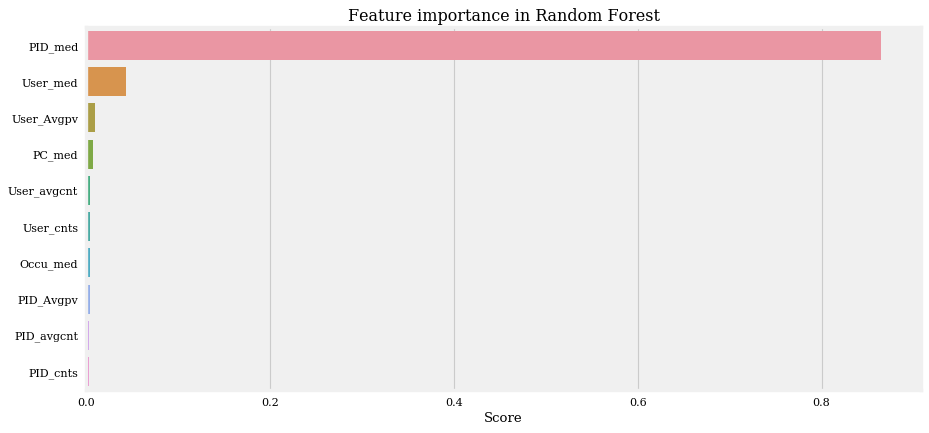

In [137]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

cols = pd.DataFrame(RF.feature_importances_, X.columns, columns=['Score']).sort_values(by='Score', ascending=False)[:10]
sns.barplot(x=cols.Score, y=cols.index)
plt.title('Feature importance in Random Forest')
plt.show()
